In [1]:
import importlib
import subprocess
import sys

# Dict of required packages
required_packages = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "sklearn": "scikit-learn",
    "tensorflow": "tensorflow",
    "datasets": "datasets",
    "transformers": "transformers",
    "tf-keras": "tf-keras",
    "typing": "typing",
    "seaborn": "seaborn",
    "nltk": "nltk"
}

def install_and_import(pkg_name, install_name=None):
    install_name = install_name or pkg_name
    try:
        importlib.import_module(pkg_name)
        print(f"{pkg_name} is already installed.")
    except ImportError:
        print(f"{pkg_name} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])

# Loop and ensure all are installed
for pkg, pip_name in required_packages.items():
    install_and_import(pkg, pip_name)

####################################################################################################################################
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.utils import check_random_state
import tensorflow as tf
from datasets import load_dataset
from transformers import TFBertForSequenceClassification
from transformers import AutoTokenizer
from datasets import Dataset
from typing import Dict
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import math


numpy is already installed.
pandas is already installed.
matplotlib is already installed.
sklearn is already installed.
tensorflow is already installed.
datasets is already installed.
transformers is already installed.
tf-keras not found. Installing...
typing is already installed.
seaborn is already installed.
nltk is already installed.



In [2]:
# Set random states for reproducability
RandomState = 42
random.seed(RandomState)
np.random.seed(RandomState)
skl_rand = check_random_state(RandomState)
tf.random.set_seed(RandomState)

print("Random seeds defined.")

Random seeds defined.


TO DO:
- Dataset Loading/Choosing ✅
- Dataset Cleaning ✅
- Exploratory Data Analysis
- Baseline (TBD)
- BERT fine-tuning to classify text
- Error Analysis / Robustness Testing

# Dataset Loading/Choosing

- LLM - Detect AI Generated Text Dataset (28k essays)
https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset.
- Dataset Card for AI Text Dectection Pile (1.4mil essays)
https://huggingface.co/datasets/artem9k/ai-text-detection-pile
- Raid (10+mil essays from 10 genres) https://github.com/liamdugan/raid

# Dataset Cleaning

- Lowercasing (optional with BERT since it's often case-aware depending on the model)
- Removing HTML tags, extra spaces
- Filtering by length (exclude very short texts)
- Removing duplicates
- Language detection if you need only English
- Where possible tag which model AI text is from

In [3]:
# Different selection of data
# Takes a long time to load first time around...
data_all = load_dataset("liamdugan/raid", "raid")
train_data = data_all["train"]
train_data_subset = train_data.shuffle(seed=RandomState).select(range(10000))


Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
train_data_subset.features

{'id': Value(dtype='string', id=None),
 'adv_source_id': Value(dtype='string', id=None),
 'source_id': Value(dtype='string', id=None),
 'model': Value(dtype='string', id=None),
 'decoding': Value(dtype='string', id=None),
 'repetition_penalty': Value(dtype='string', id=None),
 'attack': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'prompt': Value(dtype='string', id=None),
 'generation': Value(dtype='string', id=None)}

In [36]:
# Combine title + generation into one for training
def prepare_text(dataset: Dict) -> Dict:
    if dataset["title"] is None or dataset["generation"] is None:
        return None
    dataset["text"] = dataset["title"].strip() + " " + dataset["generation"].strip()
    return dataset

# Encode binary labels
def encode_label(dataset: Dict, label_map={"human": 0, "machine": 1}) -> Dict:
    dataset["label"] = label_map.get(dataset["model"], -1)
    return dataset

# Tokenization function
def tokenize(dataset: Dict, tokenizer) -> Dict:
    tokens = tokenizer(
        dataset["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["label"] = dataset["label"]
    return tokens

# Full "main" pipeline
def prepare_dataset_for_bert(dataset, tokenizer_name="bert-base-uncased"):
    # Filter rows with missing title or generation
    dataset = dataset.filter(lambda x: x["title"] is not None and x["generation"] is not None)
    dataset = dataset.map(prepare_text)
    
    # Encode labels
    dataset = dataset.map(encode_label)
    dataset = dataset.filter(lambda x: x["label"] != -1)
    
    # Tokenize
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    dataset = dataset.map(lambda x: tokenize(x, tokenizer), batched=False)

    # Set format for tf.data.Dataset
    dataset.set_format(type="tensorflow", columns=["input_ids", "attention_mask", "label"])
    
    # Convert to tf.data.Dataset
    features = {
        "input_ids": tf.TensorSpec(shape=(512,), dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=(512,), dtype=tf.int32),
    }

    tf_dataset = dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols="label",
        shuffle=True,
        batch_size=16,
        collate_fn=None
    )
    
    return tf_dataset, tokenizer


In [6]:
pd.DataFrame(train_data_subset[:5])

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation
0,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,human,None,None,none,abstracts,FUTURE-AI: Guiding Principles and Consensus Re...,None,The recent advancements in artificial intellig...
1,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,human,None,None,none,abstracts,EdgeFlow: Achieving Practical Interactive Segm...,None,High-quality training data play a key role in ...
2,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,human,None,None,none,abstracts,Semi-supervised Contrastive Learning for Label...,None,The success of deep learning methods in medica...
3,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,human,None,None,none,abstracts,Combo Loss: Handling Input and Output Imbalanc...,None,Simultaneous segmentation of multiple organs f...
4,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,human,None,None,none,abstracts,Attention-Based 3D Seismic Fault Segmentation ...,None,Detection faults in seismic data is a crucial ...


In [7]:
train_tf_dataset, tokenizer = prepare_dataset_for_bert(train_data_subset)

The fetching of data will take some minutes...

In [ ]:
# Super basic model to validate data cleaning worked.
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
model.fit(train_tf_dataset, epochs=3)


Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Jespe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jespe\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


 4/31 [==>...........................] - ETA: 12:02 - loss: 0.3544 - accuracy: 0.9844

KeyboardInterrupt: 

Possible extra feature engineering, usefullness unsure.
BERT embeddings + handcrafted features like:
- Average sentence length
- N-gram repetition
- Ratio of stopwords Then feed that into a LightGBM/XGBoost model to compare.

# Exploratory Data Analysis (EDA)
- Text length distributions
- Vocabulary richness (e.g. unique words)
- POS tag distribution (maybe AI uses more nouns, fewer adjectives?)
- Visualizations: word clouds, frequency plots
- Clustering to check for seperability of classes
- .
- Comparing perplexity charts of AI model text and human text, can help understand the complexity of the task at hand, due to the variety of distributions.

In [5]:
train_data_subset

Dataset({
    features: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation'],
    num_rows: 10000
})

In [6]:
df = train_data_subset.to_pandas()

# Text Column Creation
df['title'] = df['title'].fillna('')
df['generation'] = df['generation'].fillna('')
df['text'] = df['title'] + ' ' + df['generation']

print("Shape:", df.shape)
print(df[['model', 'domain']].value_counts().reset_index(name='count').head())
print("\nMissing values:\n", df.isnull().sum())


Shape: (10000, 12)
      model  domain  count
0      gpt2    news    178
1   mistral   books    173
2  mpt-chat   books    171
3       mpt    news    170
4       mpt  reddit    169

Missing values:
 id                      0
adv_source_id           0
source_id               0
model                   0
decoding              321
repetition_penalty    321
attack                  0
domain                  0
title                   0
prompt                321
generation              0
text                    0
dtype: int64


### Count in each model and domain

In [7]:
model_counts = df['model'].value_counts().reset_index()
model_counts.columns = ['model', 'count']
print("Model Distribution:\n", model_counts)

domain_counts = df['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'count']
print("\nDomain Distribution:\n", domain_counts)


Model Distribution:
            model  count
0           gpt2   1174
1        mistral   1160
2   mistral-chat   1144
3            mpt   1141
4       mpt-chat   1140
5     llama-chat   1089
6        chatgpt    572
7    cohere-chat    571
8           gpt4    565
9           gpt3    564
10        cohere    559
11         human    321

Domain Distribution:
       domain  count
0      books   1397
1     reddit   1354
2       news   1339
3     poetry   1337
4  abstracts   1312
5       wiki   1305
6    recipes   1253
7    reviews    703


It makes sense there is missing values in those columns since they are related to AI model generation, so those missing values are human data entries.

### Text Lengths

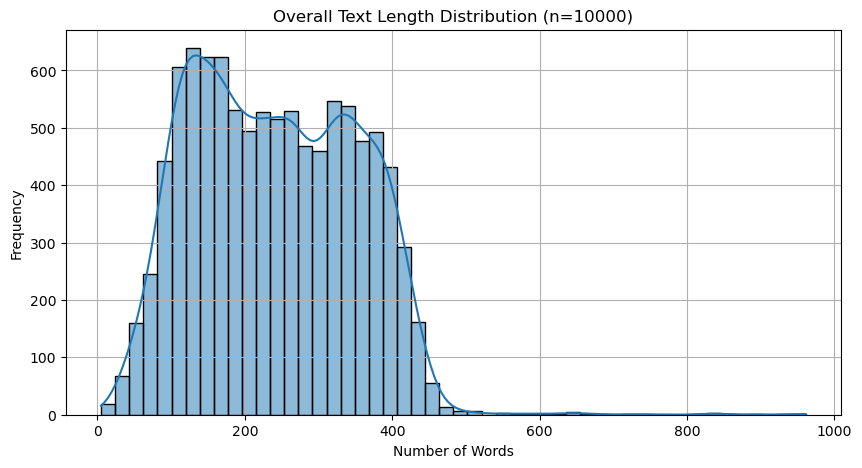

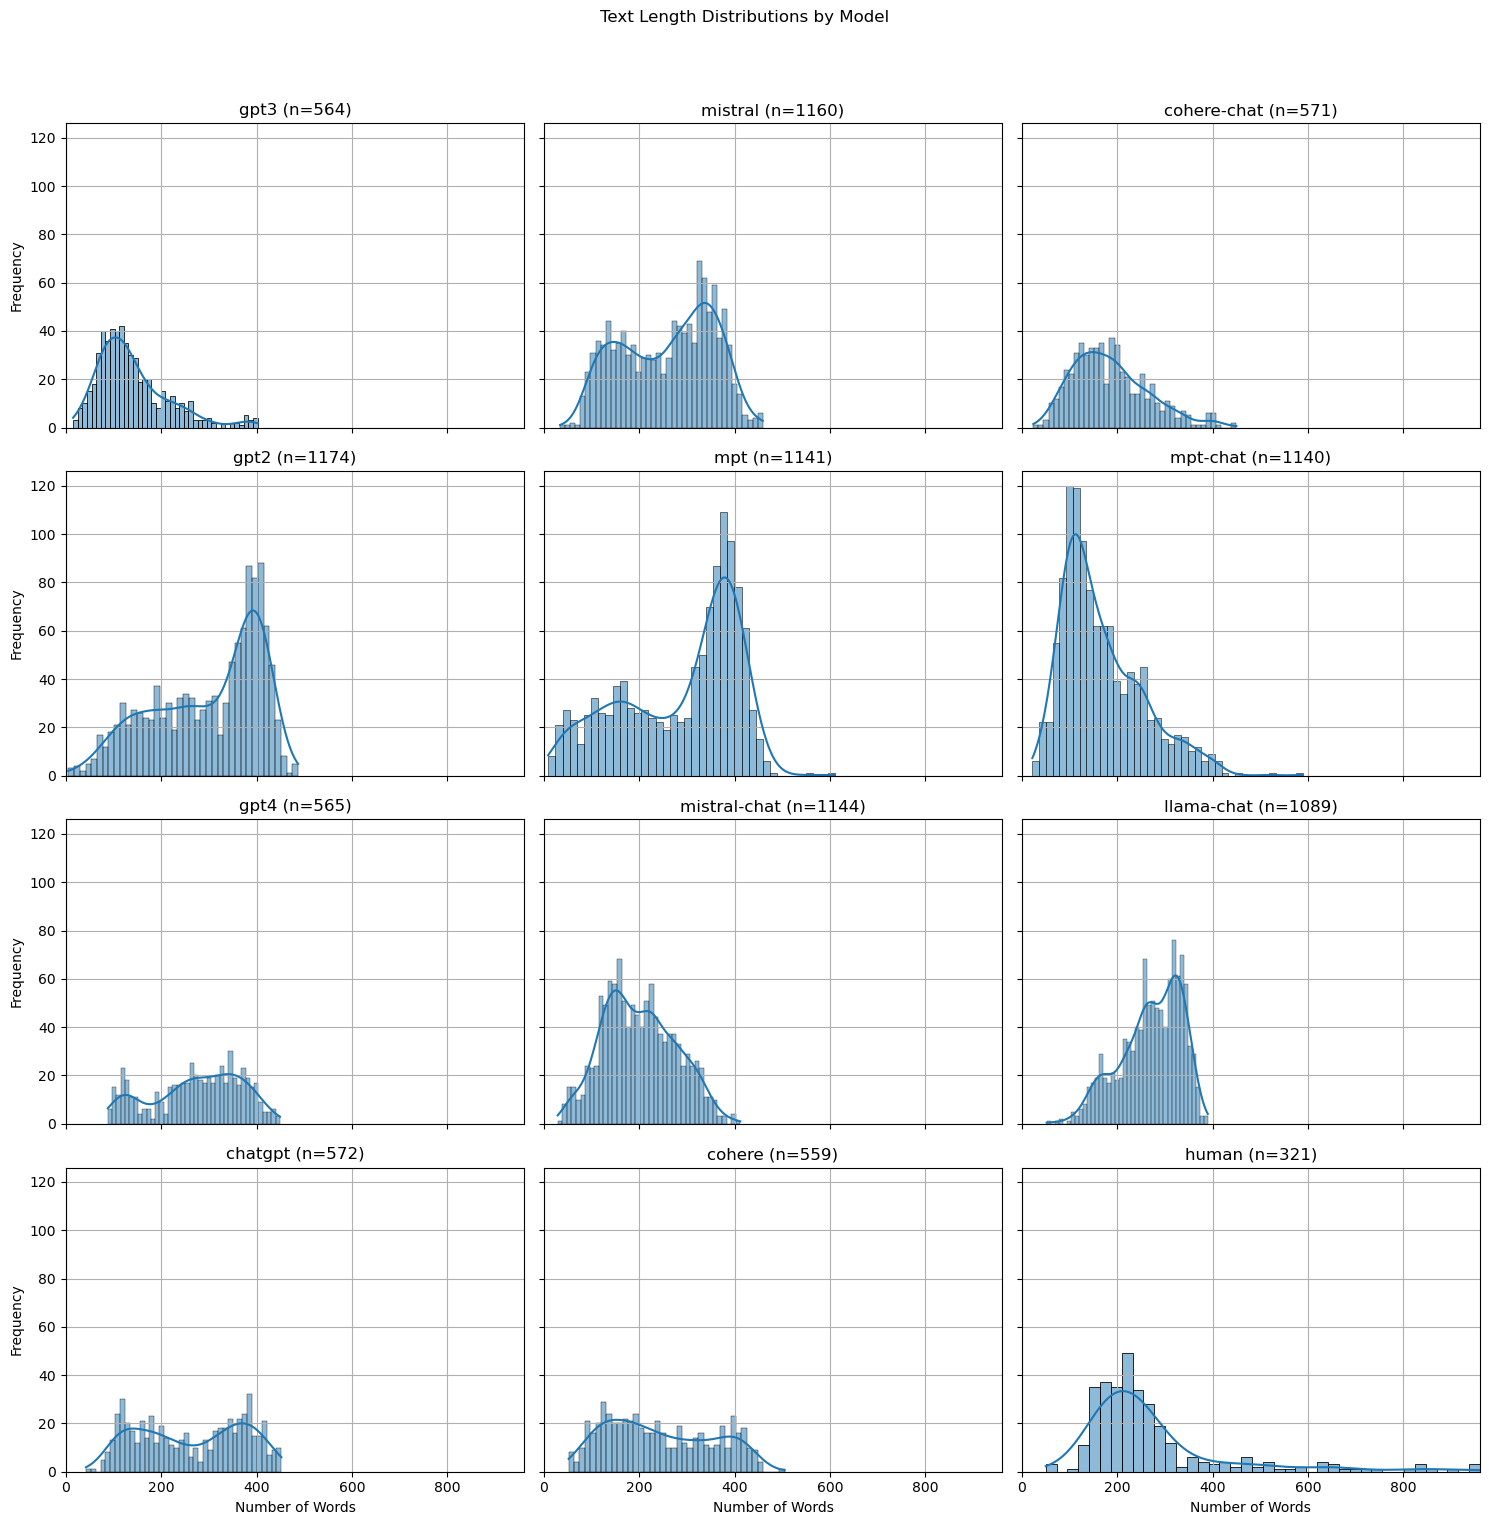

In [8]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate text lengths
df['text_len_char'] = df['text'].apply(len)
df['text_len_word'] = df['text'].apply(lambda x: len(x.split()))

# === 1. Plot Overall Distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(df['text_len_word'], bins=50, kde=True)
plt.title(f'Overall Text Length Distribution (n={len(df)})')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# subplot grid
unique_models = df['model'].dropna().unique()
n_models = len(unique_models)

n_cols = 3
n_rows = math.ceil(n_models / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

max_x = df['text_len_word'].max()

for i, model in enumerate(unique_models):
    model_data = df[df['model'] == model]['text_len_word']
    ax = axes[i]
    sns.histplot(model_data, bins=40, kde=True, ax=ax)
    ax.set_title(f'{model} (n={len(model_data)})')
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, max_x)
    ax.grid()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Text Length Distributions by Model', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Boxplots by Model and Domain

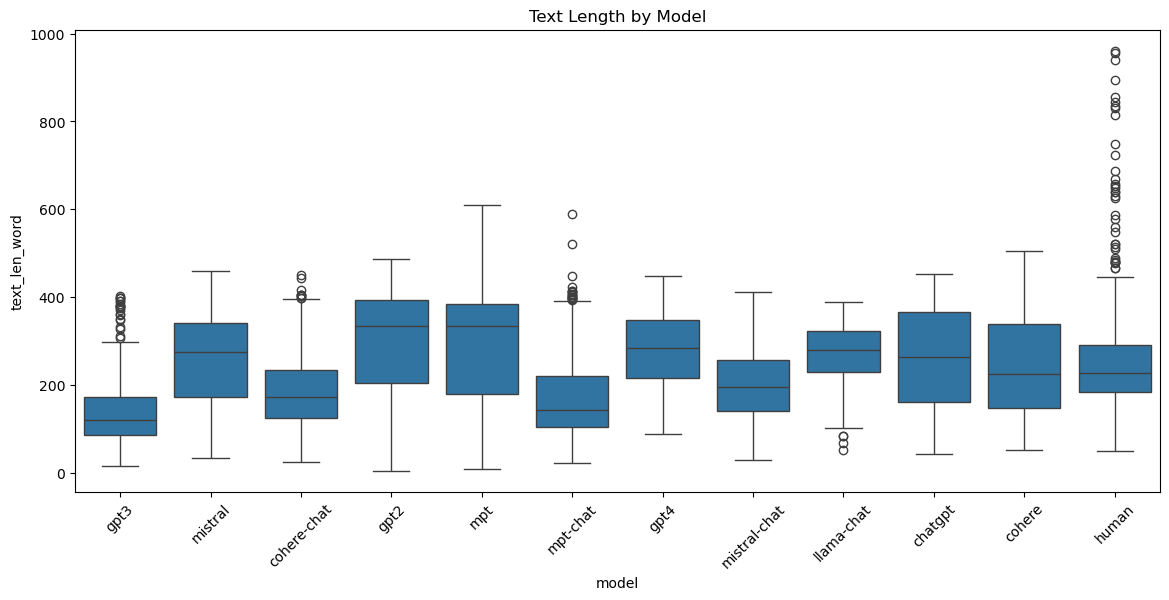

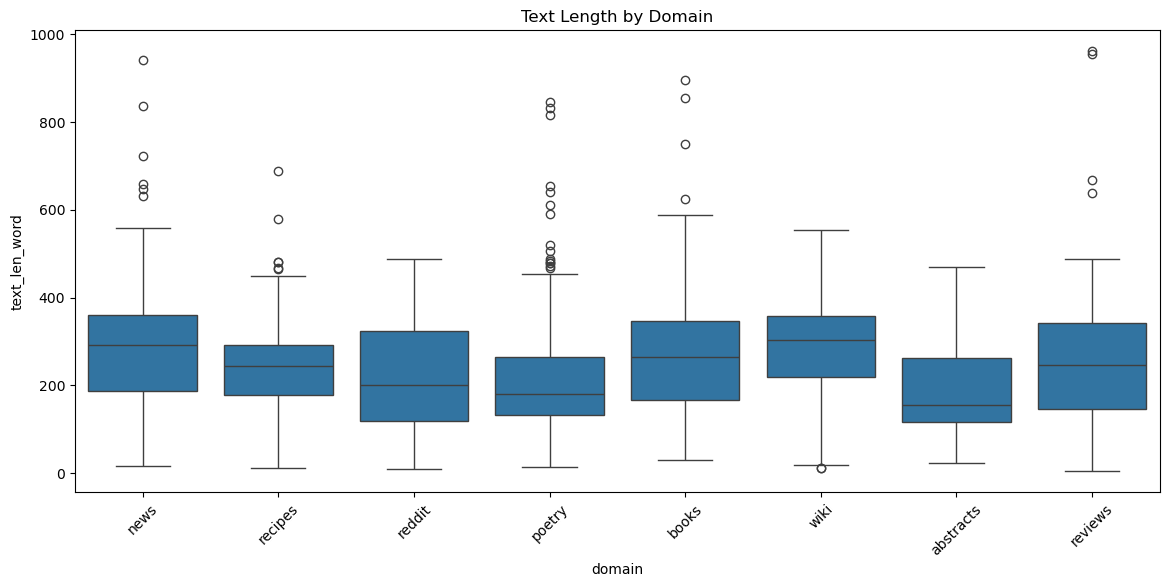

In [9]:
# Boxplots by model and domain
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='model', y='text_len_word')
plt.title('Text Length by Model')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='domain', y='text_len_word')
plt.title('Text Length by Domain')
plt.xticks(rotation=45)
plt.show()

### Heatmap of model vs domain and each combination

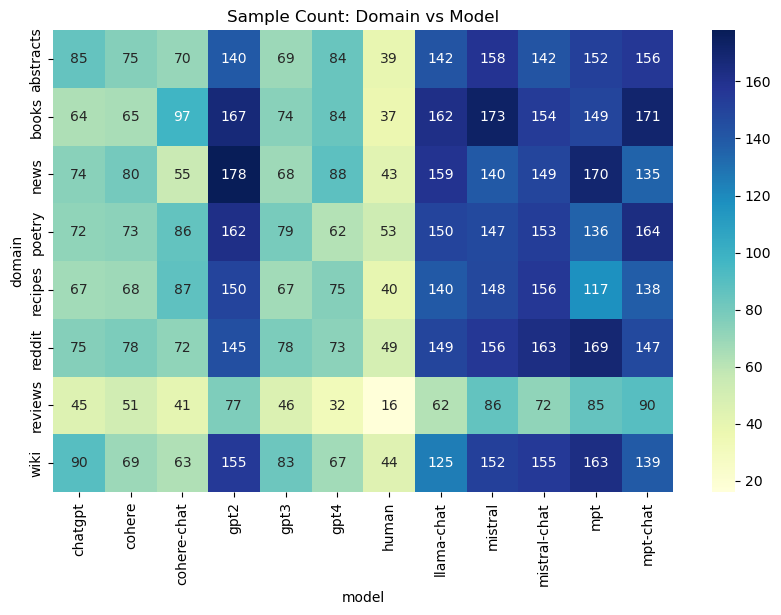

In [10]:
pivot = df.pivot_table(index='domain', columns='model', aggfunc='size', fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Sample Count: Domain vs Model')
plt.show()

### Preprocessing for Word Frequency

In [8]:
# Download resources
nltk.download('punkt')
nltk.download('stopwords')

# Sample DataFrame (replace with your actual df)
# df = pd.read_csv('your_file.csv')

# Preprocessing
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    return [word for word in tokens if word.isalpha() and word not in stop_words]

df['tokens'] = df['text'].astype(str).apply(clean_and_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jespe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jespe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
df['tokens']

0       [china, blocks, google, news, site, china, blo...
1                                    [shawerma, chawerma]
2       [gen, z, member, ashamed, prince, phillip, mem...
3       [sky, door, way, spanning, endlessly, across, ...
4       [mortal, danger, novel, set, near, future, wor...
                              ...                        
9995    [fantastic, beasts, find, great, beasts, find,...
9996    [contrastive, registration, unsupervised, medi...
9997     [screens, turning, grey, restart, pc, everytime]
9998         [rational, sets, euclidean, spaces, spheres]
9999    [industrial, output, falls, japan, japans, eco...
Name: tokens, Length: 10000, dtype: object

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jespe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Is the in stopwords True
Is the in all_tokens False
word_freq Counter({'thе': 9658, 'аnd': 6005, 'оf': 5533, 'а': 5324, 'also': 5068, 'cup': 4980, 'tо': 4920, 'one': 4339, 'іn': 3535, 'im': 3332, 'new': 3205, 'time': 2925, 'like': 2835, 'world': 2664, 'іs': 2664, 'life': 2603, 'film': 2504, 'would': 2364, 'people': 2357, 'said': 2323, 'us': 2240, 'two': 2204, 'thаt': 2111, 'make': 2020, 'segmentation': 2009, 'love': 2008, 'novel': 1988, 'first': 1986, 'work': 1943, 'including': 1893, 'way': 1864, 'teaspoon': 1828, 'fоr': 1811, 'image': 1782, 'years': 1753, 'chopped': 1713, 'minutes': 1689, 'many': 1688, 'well': 1684, 'set': 1682, 'story': 1655, 'together': 1637, 'ive': 1619, 'salt': 1563, 'wіth': 1558, 'even': 1550, 'good': 1549, 'movie': 1530, 'add': 1516, 'place': 1515, 'using': 1515, 'man': 1496, 'use': 1490, 'large': 1483, 'paper': 1479, 'could': 1477, 'get': 1458, 'fresh': 1448, 'may': 1437, 'find': 1430, 'see': 1423, 'know': 1417, 'sure': 1389, 'pepper': 1381, 'day': 1380, 'made'

Text(0, 0.5, 'Frequency')

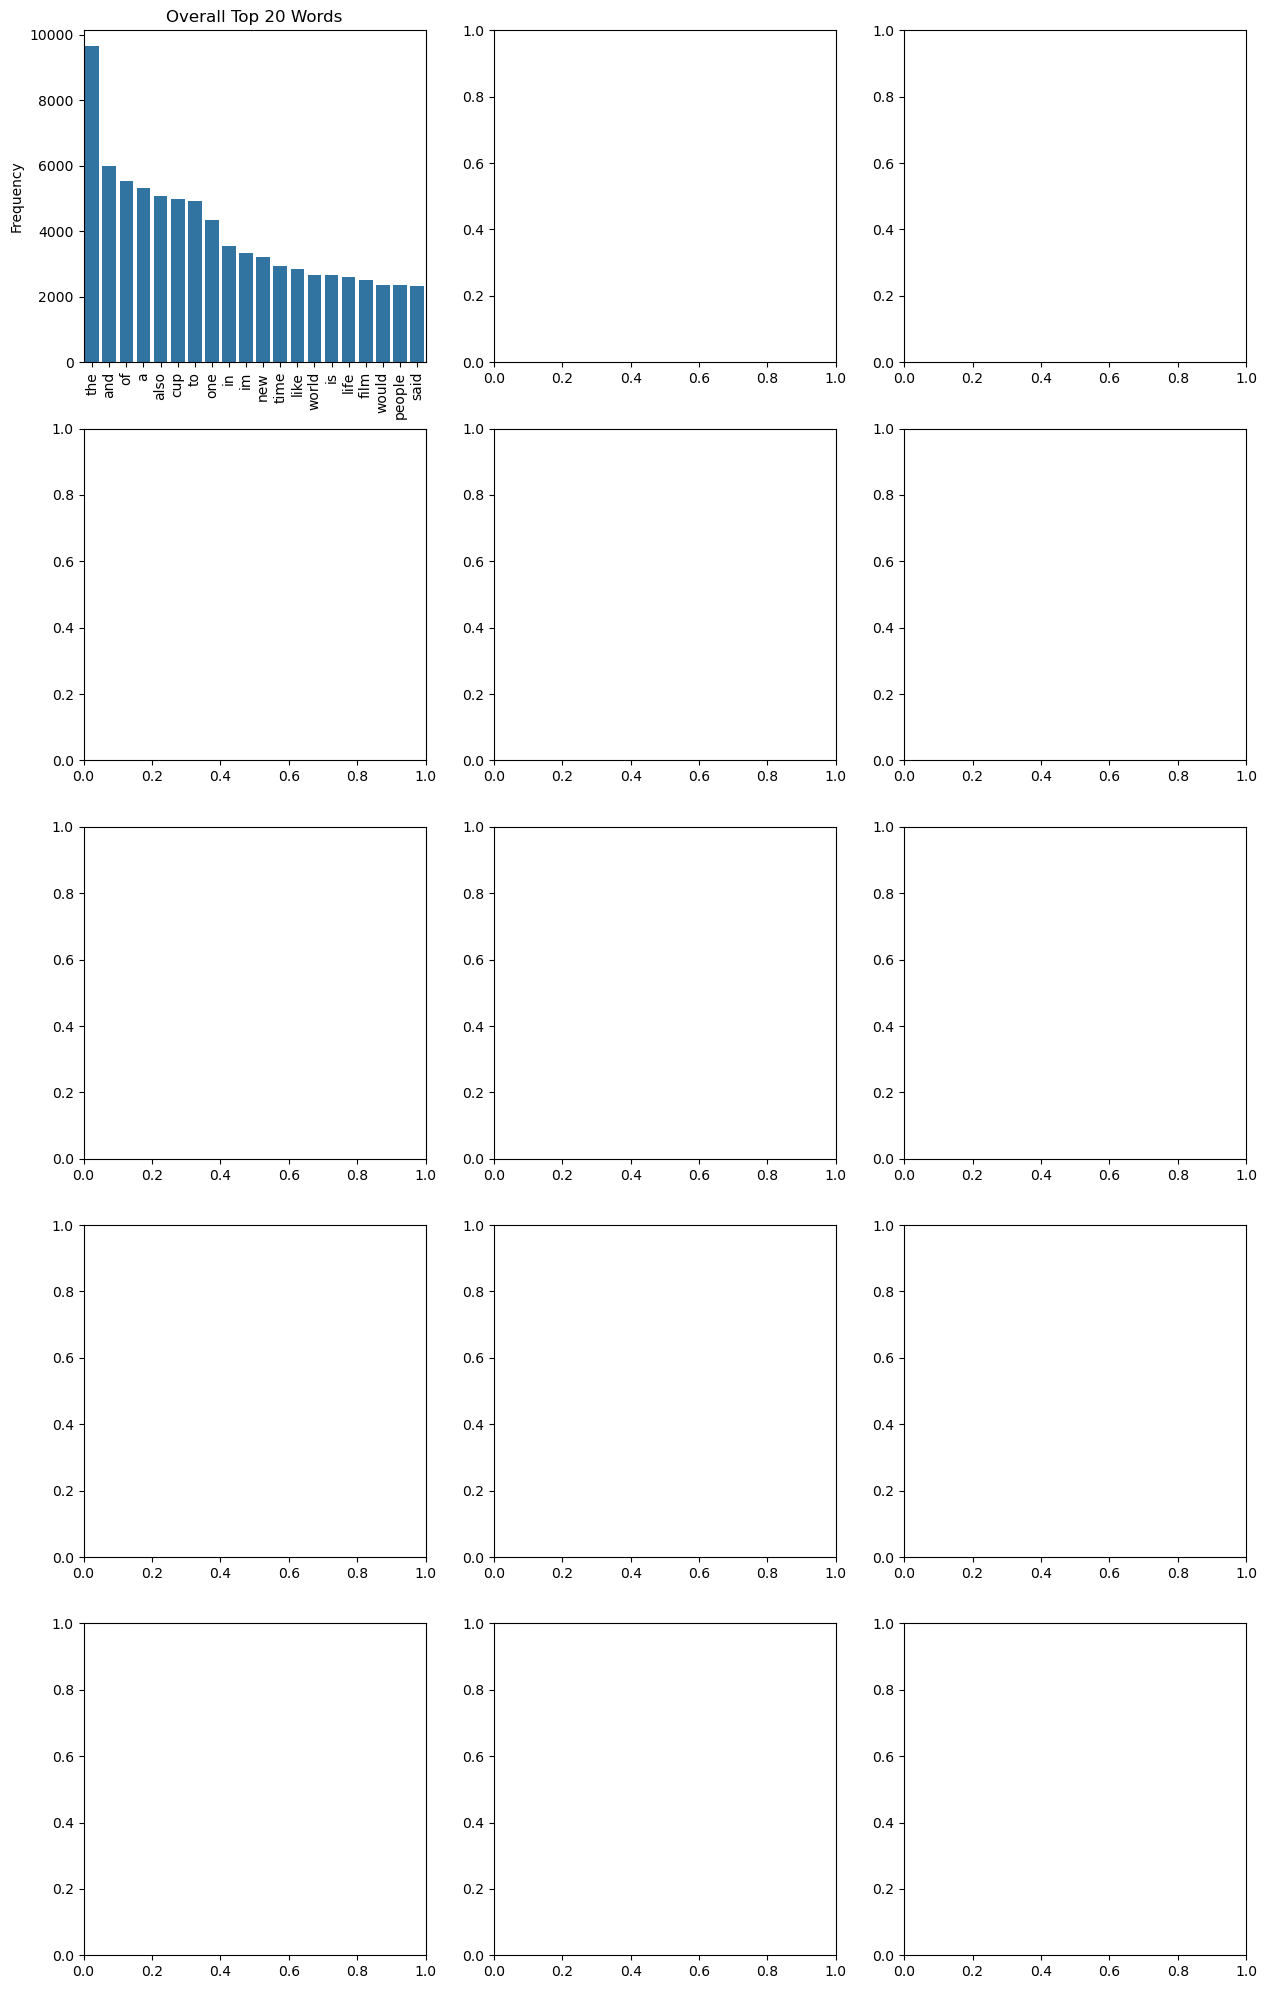

In [ ]:
nltk.download('stopwords')  # only needs to be run once

stop_words = set(stopwords.words('english'))
print("Is the in stopwords", "the" in stop_words)
# Filter out stop words
all_tokens = [word for tokens in df['tokens'] for word in tokens if word.lower() not in stop_words]
print("Is the in all_tokens", "the" in all_tokens)

word_freq = Counter(all_tokens)
print("word_freq",word_freq)
print()
common_words = word_freq.most_common(20)
print("most common", common_words)
words, freqs = zip(*common_words)
print()
print(word_freq)

# Plot
unique_models = df['model'].dropna().unique()
n_models = len(unique_models)
total_plots = n_models + 1
n_cols = 3
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Overall plot
sns.barplot(x=list(words), y=list(freqs), ax=axes[0])
axes[0].set_title("Overall Top 20 Words")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylabel("Frequency")


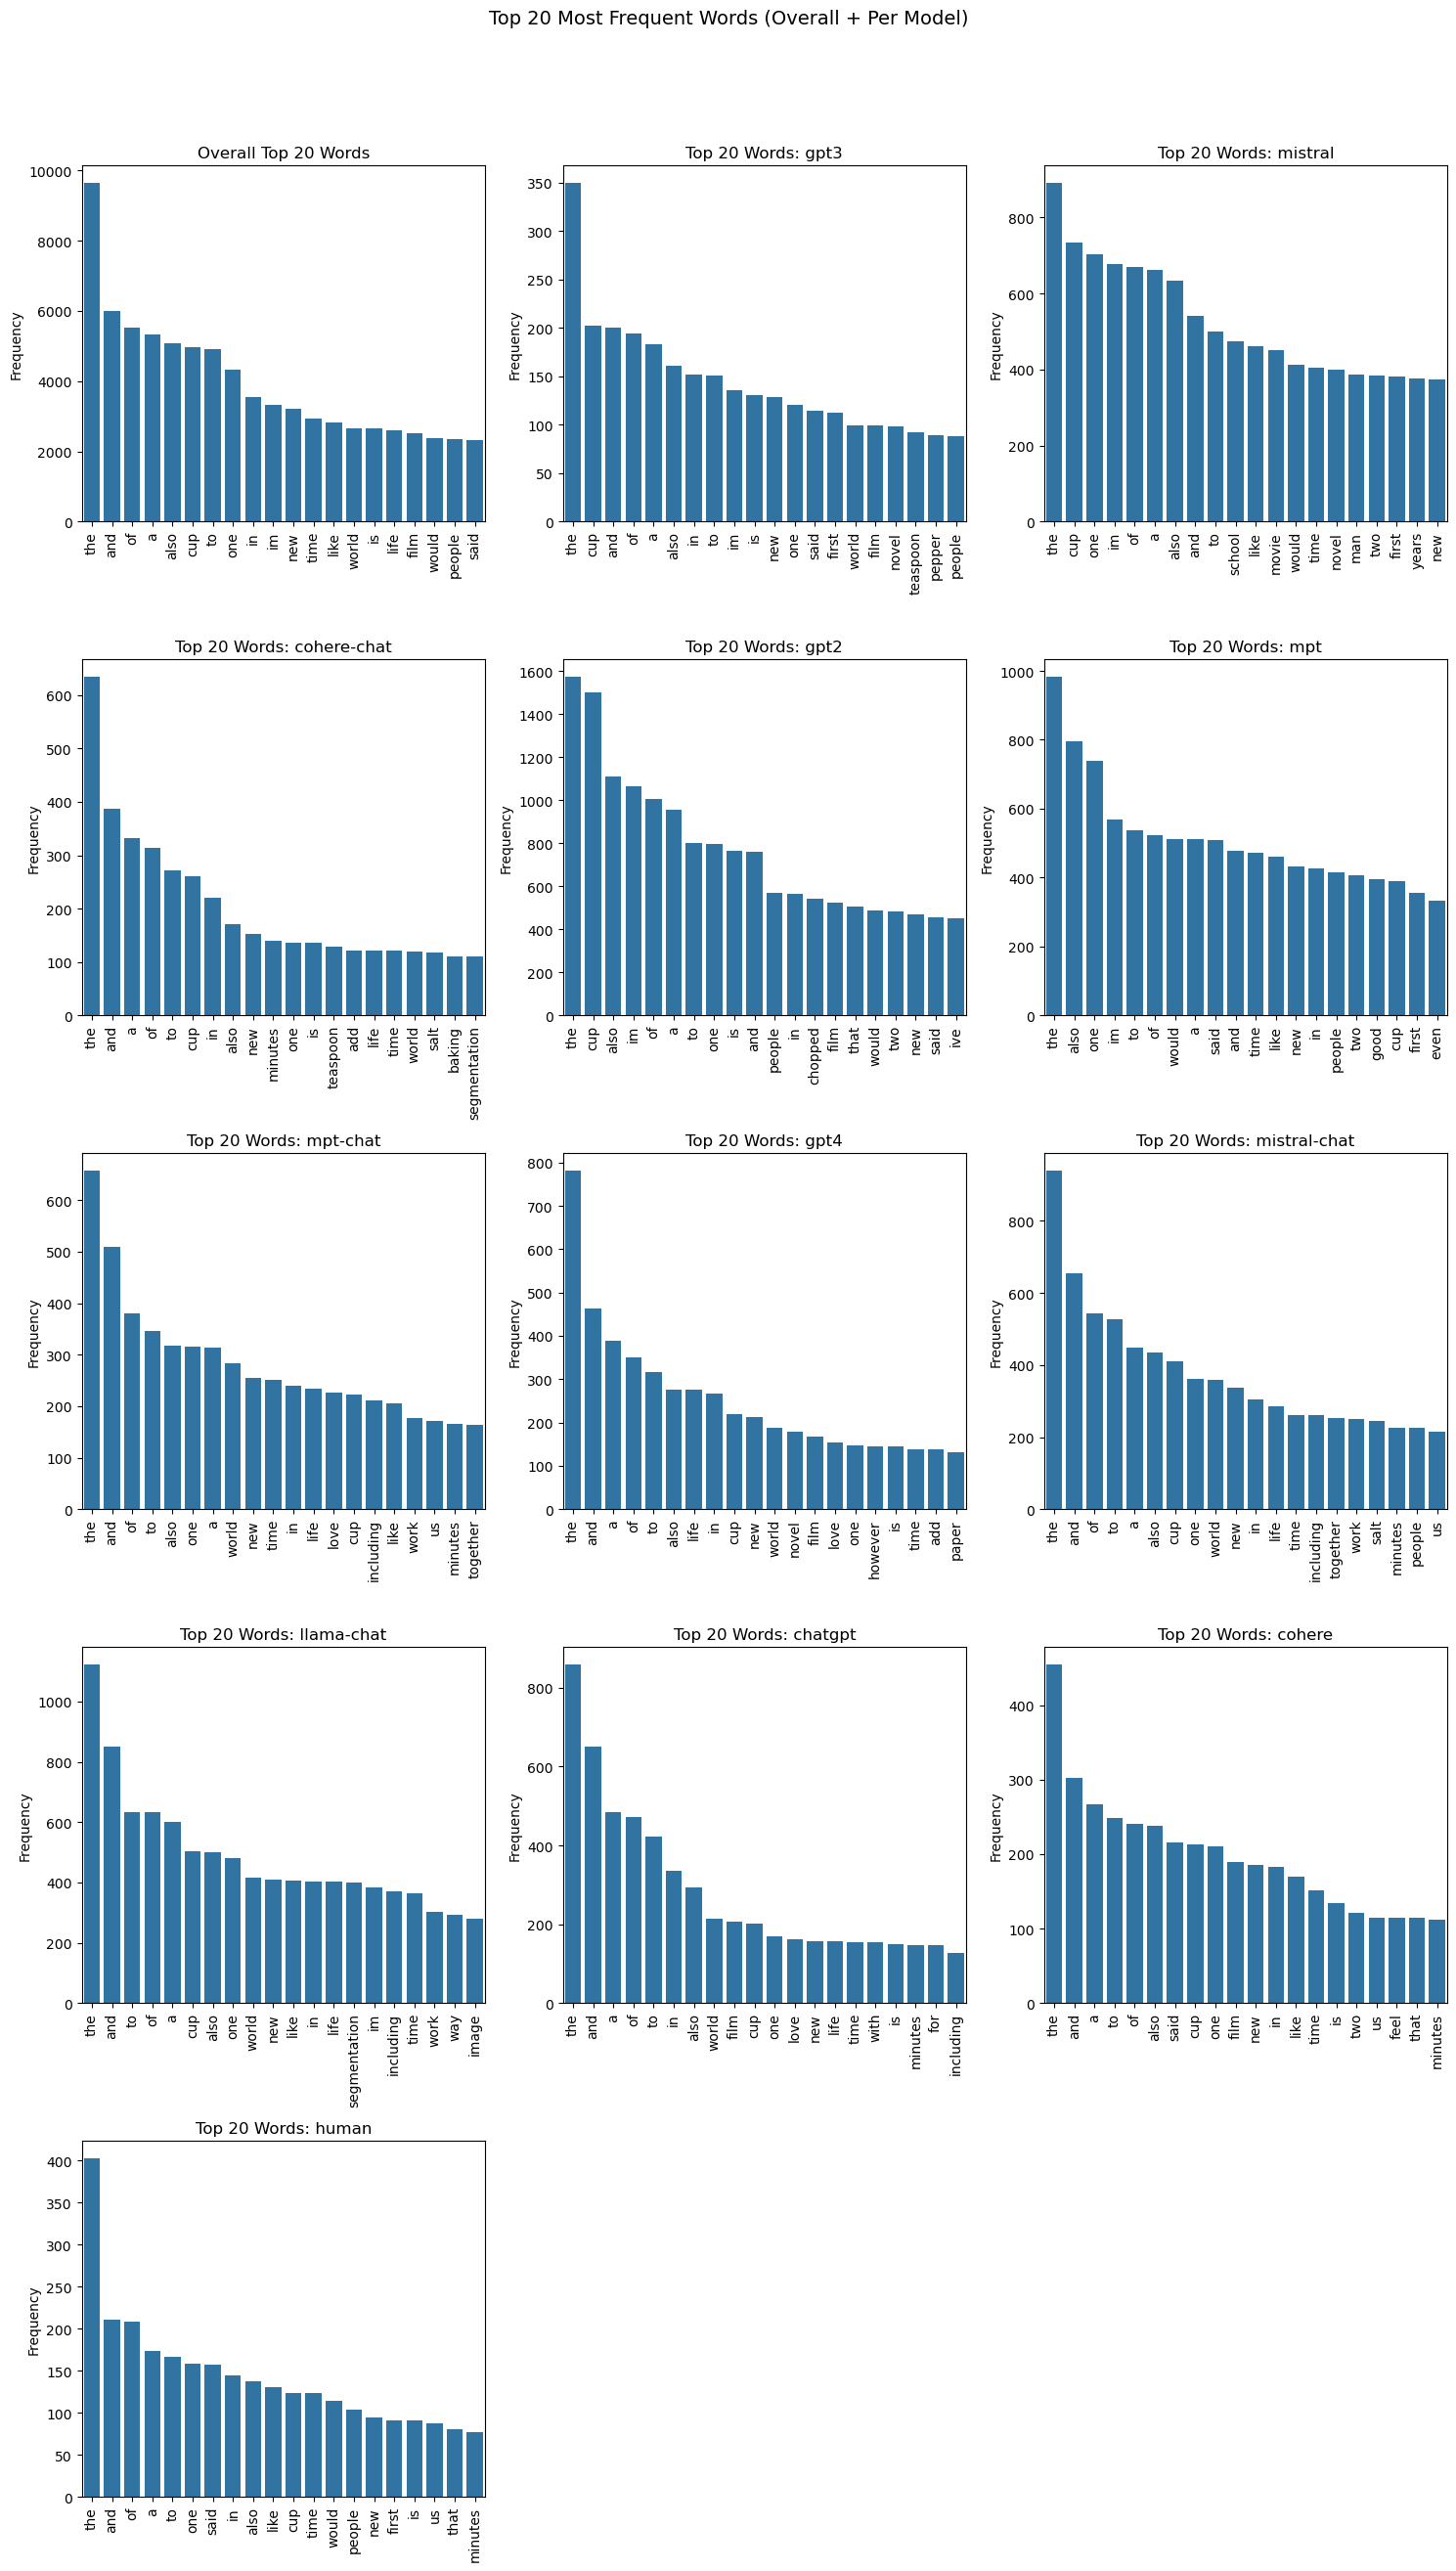

In [19]:
# Overall tokens
all_tokens = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_tokens)
common_words = word_freq.most_common(20)
words, freqs = zip(*common_words)

# Plotting
unique_models = df['model'].dropna().unique()
n_models = len(unique_models)
total_plots = n_models + 1
n_cols = 3
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Overall plot
sns.barplot(x=list(words), y=list(freqs), ax=axes[0])
axes[0].set_title("Overall Top 20 Words")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylabel("Frequency")

# Per-model plots
for i, model in enumerate(unique_models):
    model_tokens = df[df['model'] == model]['tokens']
    model_words = [word for tokens in model_tokens for word in tokens]
    model_word_freq = Counter(model_words).most_common(20)

    if model_word_freq:
        words_m, freqs_m = zip(*model_word_freq)
        sns.barplot(x=list(words_m), y=list(freqs_m), ax=axes[i + 1])
        axes[i + 1].set_title(f"Top 20 Words: {model}")
        axes[i + 1].tick_params(axis='x', rotation=90)
        axes[i + 1].set_ylabel("Frequency")
    else:
        axes[i + 1].text(0.5, 0.5, "No data", ha='center', va='center')
        axes[i + 1].set_title(f"{model} (No Data)")
        axes[i + 1].axis('off')

# Clean up unused subplots
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Top 20 Most Frequent Words (Overall + Per Model)", fontsize=14, y=1.05)
plt.show()

# Baseline (TBD)

- Basic baseline logistic regression etc (Might not be relevant)
- Basic Deep learning artitecture
- Base BERT
- Maybe a basic baseline and a base BERT to see how much performance BERT adds and how much fine-tuned BERT additionally adds.

# BERT fine-tuning to classify text

- BERT vs RoBERTa vs DistilBERT
- RoBERTa often performs better in classification tasks

# Error Analysis / Robustness Testing

- What types of errors does it make confusion matrix?
- Is the model biased toward longer/shorter texts?
- Attention analysis (using tools like BertViz)
- Check if BERT overfits to text length or formatting
- Does it misclassify texts on certain topics?
- Could it unfairly flag texts written by non-native speakers?
- Does it perform better on specific outpurs from specific models?
- Small edits (punctuation, synonyms) and how does they affect the model?
- Test synonym replacements (e.g., "happy" → "joyful") with slight paraphrasing

# Explainability

- Attention Heatmap (with bertviz or transformers-interpret)
- Visualize token importance
- SHAP map

# (Option extra if time allows) Own trained text generator, compare its outputs predictions to the ones from other models